In [19]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(directory)

In [214]:
cellpose_model.diam_labels

32.42986

In [107]:
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)

a
a
a
a
a
a
a
a
a
a
a


In [9]:
print(cellpose_model.mkldnn)

None


In [162]:
from cellpose import core

unet = core.UnetModel(pretrained_model=directory)
unet.net_type

'unet3_residual_off_style_off_concatenation_on'

In [215]:
from cellpose import resnet_torch

cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)
print(cpnet.diam_mean)
print(cpnet.diam_labels)

Parameter containing:
tensor([17.])
Parameter containing:
tensor([32.4299])


In [217]:
rescale = cpnet.diam_mean/cpnet.diam_labels
print(rescale)

tensor([0.5242])


In [207]:
cpnet.cell_threshold

AttributeError: 'CPnet' object has no attribute 'cell_threshold'

In [234]:
import cv2

imgs = cv2.resize(images[0], (512 , 512), interpolation=cv2.INTER_NEAREST)

print(imgs.shape)

(512, 512)


In [233]:
Ly = int(images[0].shape[-2] * [0.5,0.5][-2])
Lx = int(images[0].shape[-1] * [0.5,0.5][-1])

print(Ly, Lx)

512 512


In [241]:
from cellpose import transforms

x = transforms.resize_image(images[0], rsz=[0.5,0.5],no_channels=True)
#x = images[0].astype(np.float32)
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0)
x = np.concatenate((x, x), axis=0)
x = torch.from_numpy(x)
x = x.unsqueeze(0)
#expand dimenstions of x
print(x.shape)
print(x.dtype)
print(x.device)
y, style = cpnet(x)

torch.Size([1, 2, 512, 512])
torch.float32
cpu


In [242]:


print(y.shape)
detranspose = (1,2,0)
y_d = np.transpose(y.detach().numpy()[0], detranspose)
print(y_d.shape)

torch.Size([1, 3, 512, 512])
(512, 512, 3)


In [243]:
from cellpose import utils

masks = utils.get_masks_unet(y_d, cell_threshold=2.0, boundary_threshold=0.5)
print(masks.shape)
masks = utils.fill_holes_and_remove_small_masks(masks, min_size=15)

(512, 512)


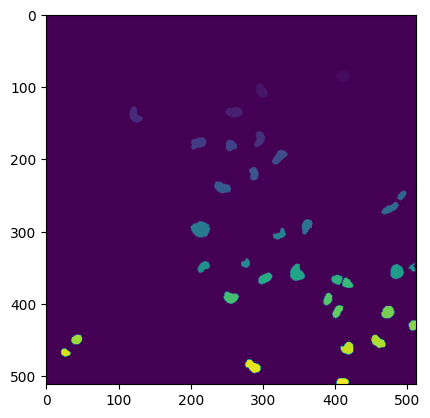

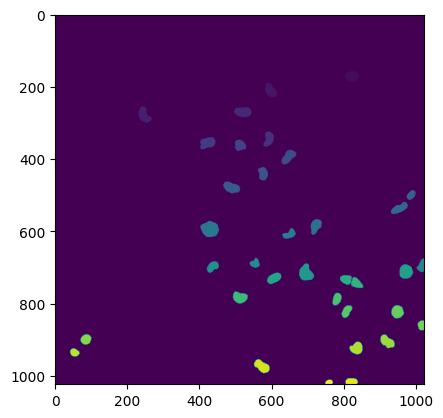

In [244]:
plt.imshow(masks)
plt.show()

plt.imshow(training_cell_masks[0])
plt.show()

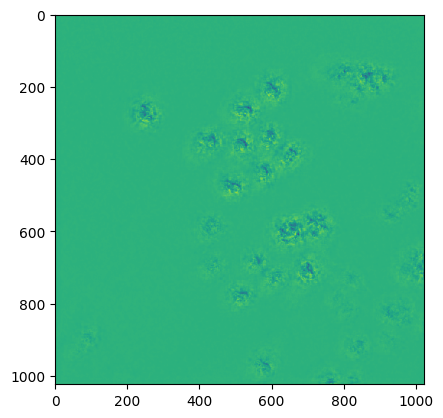

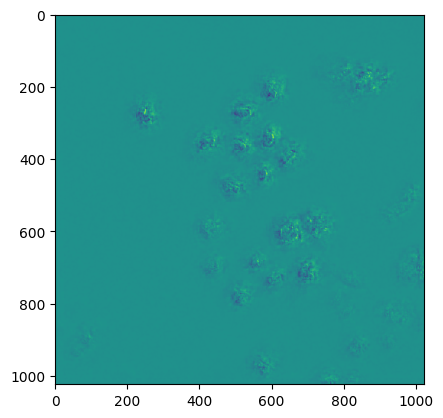

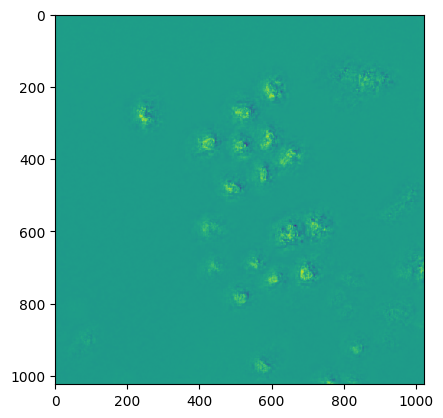

In [61]:
import matplotlib.pyplot as plt

plt.imshow(pred[0][0].cpu().detach().numpy()[0])
plt.show()
plt.imshow(pred[0][0].cpu().detach().numpy()[1])
plt.show()
plt.imshow(pred[0][0].cpu().detach().numpy()[2])
plt.show()

In [3]:
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)

a
a
a
a
a
a
a
a
a
a
a


In [4]:
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, 1024, 256):
            for j in range(0, 1024, 256):
                sub_img = image[i:i+256, j:j+256]
                splitted.append(sub_img)
    return splitted

In [5]:
training_images = images

#normalise the probability maps
pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_probability_maps]
#binarise the cell masks
cm_binary = [np.where(image > 0, 1.0, 0.0) for image in training_cell_masks]

#pad the images, probability maps and cell masks to 1024x1024
images_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in training_images]
pm_norm_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in pm_normalised]
cm_bin_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cm_binary]

#split the images, probability maps and cell masks into 256x256 images
images_pad_split = split_image_set(images_pad)
pm_norm_pad_split = split_image_set(pm_norm_pad)
cm_bin_pad_split = split_image_set(cm_bin_pad)

#augment with rotations
images_rotated = []
pm_rotated = []
cm_rotated = []
for i in range(len(images_pad_split)):
    for j in range(1,4):
        images_rotated.append(np.rot90(images_pad_split[i],j))
        pm_rotated.append(np.rot90(pm_norm_pad_split[i],j))
        cm_rotated.append(np.rot90(cm_bin_pad_split[i],j))

#remove the images from cm_bin_pad_split that only have 0s, and remove them from images_pad_split and pm_norm_pad_split
images_pad_split_filtered = [images_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
pm_norm_pad_split_filtered = [pm_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
cm_bin_pad_split_filtered = [img for img in cm_rotated if np.sum(img) > 0]

print(len(images_pad_split_filtered), len(pm_norm_pad_split_filtered), len(cm_bin_pad_split_filtered))

468 468 468


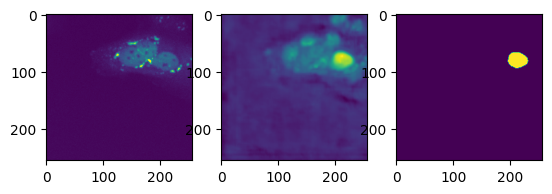

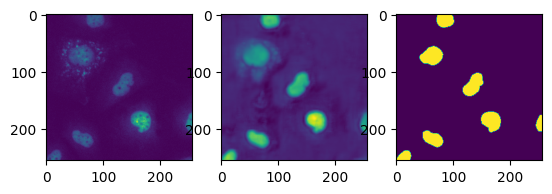

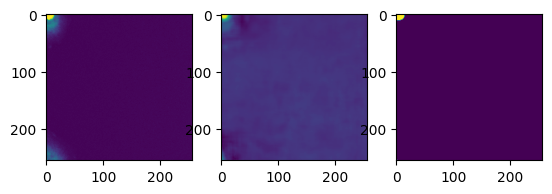

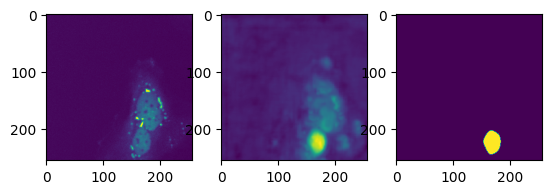

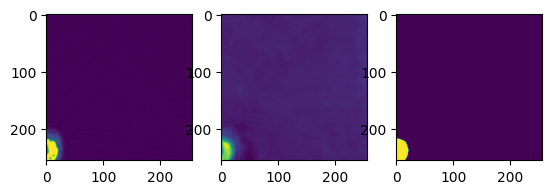

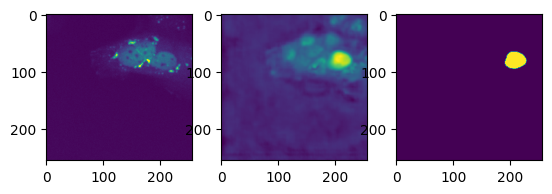

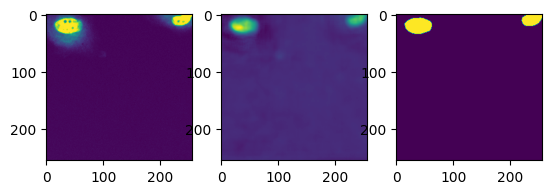

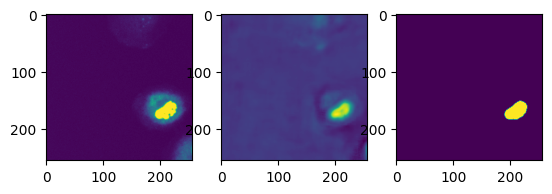

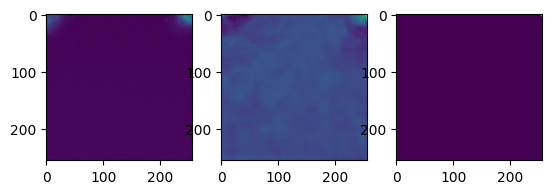

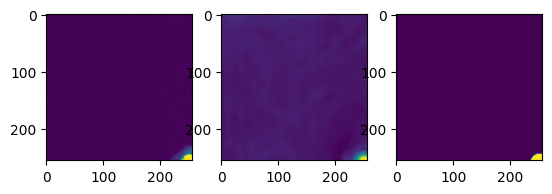

In [6]:
import matplotlib.pyplot as plt
import random

for j in range(10):
    i = random.randint(0, len(images_pad_split_filtered))

    plt.subplot(1,3,1)
    image = images_pad_split_filtered[i]
    #normalise the image
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    plt.imshow(image)

    plt.subplot(1,3,2)
    plt.imshow(pm_norm_pad_split_filtered[i])

    plt.subplot(1,3,3)
    plt.imshow(cm_bin_pad_split_filtered[i])

    plt.show()

In [7]:
print(cm_bin_pad_split_filtered[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
